# Berücksichtigung des Schätzrisikos: Portfolio-Resampling 

## Grundlagen

Die Motivation der Resampling-Methode beruht auf der Erkenntnis, dass jede ermittelte Effizienzkurve mit Unsicherheit behaftet ist. Die Effizienzkurve wird auf Basis der Eingangsparameter ($\mu$ und $\Sigma$) berechnet. Da die wahren Werte dieser Parameter ex ante unbekannt sind und nur geschätzt werden können, ist die wahre Effizienzkurve auch unbekannt und die ermittelte Kurve ist lediglich ein unsicherer Schätzer der wahren Effizienzkurve. Unsicherheit in den Eingangsparametern führt also zu Unsicherheit in der ermittelten Effizienzkurve.

Wie kann die Unsicherheit (das Schätzrisiko) in der Effizienzkurve quantifiziert werden? Und kann dadurch ein neuer Schätzer konstruiert werden, der dass Schätzrisiko reduziert (und damit stabilere Portfoliogewichte erzeugt, die weniger sensitiv auf Veränderungen der Eingabeparameter - dem Schätzrisiko in $\mu$ und $\Sigma$ - reagieren)? Die Resampling-Methode adressiert diese Fragen.

Die Methode gliedert sich grundsätzlich in die folgenden Schritte (vgl. ausführlicher Michaud und Michaud, 2008):

- Zunächst müssen die Eingabeparameter $\mu$ und $\Sigma$ geschätzt werden, z.B. auf Basis einer einfachen historischen Schätzung. Bezeichnen wir die Menge der geschätzten Parameter mit $\theta$, und nehmen an, dass es $m$ Wertpapiere gibt. 

- Danach werden die Gewichte des Globalen Minimum Varianz Portfolios (MVP) und des Maximum Ertrags Portfolios (MEP) bestimmt. Wir bezeichnen die erwartete Rendite des MVP mit $L$, und die des MEP mit $H$. 

- Wir diskretisieren die stetige Effizienzkurve indem wir die Anzahl $K$ an erwarteten Renditen festlegen, für die wir die Effizienzkurve (das jeweils zur Zielrendite gehörende MVP) bestimmen wollen. Ist z.B. $L=0,05$ und $H=0,20$ und wir wählen eine Menge von $K=16$ Punkten, dann bestimmen wir die Effizienzkurve für die Zielrenditen $\{0,05; 0,06; ...; 0,19; 0,20\}$. Dies ergibt $16$ unterschiedliche Punkte auf der Effizienzkurve. 

- Im Folgenden werden wir die diskretisierte Effizienzkurve in Form einer Matrix $a_K$ schreiben. Jedes Element der Matrix stellt dabei ein Portfoliogewicht dar. Die Matrix hat somit die Dimension $Kxm$ (die Zeilen repräsentieren die Zielrenditen, und die Spalten die Wertpapiere). Das Paar $(a_K, \theta)$ beschreibt folglich die Effizienzkurve ermittelt auf Basis der (z.B. historisch) geschätzten Parameter. In unserem Beispiel gibt es 16 Zeilen (Zielrenditen, gleichmäßig verteilt zwischen $L$ und $H$). 

- Wir beginnen mit der **Monte Carlo Simulation** indem wir eine Realisation $\theta_i$ aus der Wahrscheinlichkeitsverteilung von $\theta$ ziehen. $\theta_i$ und $\theta$ nennt man "statistisch äquivalent". Dies beinhaltet die folgenden Schritte: Nehmen wir z.B. an unser Anlageuniversum besteht aus $m=5$ Wertpapieren und unsere historische Renditezeitreihe hat eine Länge von $k=200$ Beobachtungen. Wir verwenden einen Zufallszahlengenerator, $\theta$ (d.h., den historisch geschätzten Vektor der erwarteten Renditen $\mu$ und die historische Varianz-Kovarianzmatrix $\Sigma$), unterstellen eine multivariate Normalverteilung für den Zufallsvektor $R_m$ der $m$ Renditen (d.h., $R_m \sim N_m(\mu,\Sigma)$), und ziehen 200 Mal jeweils fünf Renditen (d.h., eine Realisation von $R_m$) aus der unterstellten multivariaten Verteilung (muss nicht notwendigerweise die Normalverteilung sein). Auf Basis der simulierten Renditezeitreihen berechnen wir die simulierten $\mu_i$ und $\Sigma_i$, d.h. $\theta_i$.  

- Auf Basis von $\theta_i$, Neuberechnung des MVP (erwartete Rendite $L_i$) und des MEP (erwartete Rendite $H_i$). Aufteilung des Intervals $[L_i,H_i]$ in $K$ gleichmäßig verteilte Zielrenditen. In Anlehnung an das obige Beispiel mit $K=16$, für $L_i=0,03$ und $H_i=0,25$ ergeben sich die folgenden Zielrenditen: $\{0,030; 0,044; 0,058; ...; 0,236; 0,250\}$. 

- Bestimmung der effizienten Portfoliogewichte für jeden der $K$ Punkte (Ermittlung der MVP Gewichte für eine Zielrendite von 0,030; 0,044; ... usw.). Daraus resultiert eine neue $K x m$ Matrix $a_{K,i}$. 

- Wiederholung der Simulationen, so dass wir 1,000 $a_{K,i}$'s erhalten.

- Durchschnittsbildung über die 1,000 $a_{K,i}$'s. Für jeden der $K$ Punkte und $m$ Wertpapiere resultieren damit durchschnittliche Portfoliogewichte. $a^*_{K}$ bezeichnet die $Kxm$ Matrix dieser durchschnittlichen Gewichte. 

- Bestimmung der **Resampled-Effizienzkurve** durch Kombination der originalen Parameterschätzungen (z.B. historisch) $\theta=\{\mu,\Sigma\}$ mit den Durchschnittsgewichten $a^*_{K}$. 




Im Rahmen der folgenden Fallstudie wird die Resampling-Methode beispielhaft veranschaulicht. 

## Beginn der Fallstudie

Wir starten mit dem Import der benötigten Pakete. 

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy.linalg as la

### Laden und Beschreiben der Datenbasis

Der verwendete Datensatz enthält Kurshistorien der folgenden zehn Aktien: Danone, Siemens, BASF, L'Oreal, Allianz, Telecom Italia, Banco Santander, Total, BMW, Vivendi. Zudem ist als elfte Spalte die Indexhistorie des Euro Stoxx 50 im Datensatz enthalten (diese wird nicht benötigt).  
 
Die Zeitreihen umfassen 111 Monatsschlusskurse ("Adjusted Close") über den Zeitraum vom 31.12.2002 bis zum 29.2.2012.

In [ ]:
# hier den Pfad zur Datei einfügen
# cd "..."

In [3]:
# load stock returns
# sample of 10 European stocks
frame1 = pd.read_excel('Kapitel A3_4.xlsx', 'Tabelle1', index_col=0, parse_dates=True)
frame1.drop('EuroStoxx 50', axis=1, inplace=True)


In [4]:
frame1.head()

,Danone,Siemens,BASF,L'Oreal,Allianz,Telecom Italia,Banco Santander,Total,BMW,Vivendi
2002-12-31,30.2427,40.50,18.040,72.55,82.025,2.0558,5.8537,33.5794,28.92,15.39
2003-01-31,27.6478,38.15,17.260,64.30,66.860,2.0199,5.1466,30.9888,27.26,15.64
2003-02-28,25.9021,36.78,16.910,59.90,60.137,1.8927,5.3256,30.2486,26.00,13.02
2003-03-31,27.2939,37.80,17.055,55.50,41.080,2.0074,5.2361,28.6202,25.44,12.18
2003-04-30,29.9125,44.67,19.985,64.05,63.350,2.1609,6.3012,28.9903,29.87,14.60


Auf Basis von stetigen (log) Renditen werden die historischen Mittelwerte und die Varianz-Kovarianzmatrix der Renditen berechnet. 

In [5]:
# calculation of returns, and historical means and Sigma
# using log returns

returns = np.log1p(frame1.pct_change().dropna())

# historical means and covariances
means_hist = returns.mean().values
Sigma_hist = returns.cov().values

### Portfoliooptimierung mit Leerverkaufsverbot

Im Folgenden betrachten wir ausschießlich den Fall der Portfoliooptimierung mit Leerverkaufsverbot (implementiert über positive Bestandsgrenzen). Die Portfoliogewichte können also nur numerisch bestimmt werden.

Wir beginnen mit der Definition der Zielfunktionen der Optimierung: $\sigma_P^2 \rightarrow \min_{w}!$ für das GMVP bzw. für das MEP: $\mu_P \rightarrow \max_{w}!$. Die dritte Funktion berechnet die erwartete Portfoliorendite. 

In [6]:
# necessary functions for calculating the: GMVP, MRP, min and max target
# returns

# specification of target function for MRP:
def calculate_negative_portfolio_ret(w,means):
    # function that calculates negative of portfolio return
    w = np.matrix(w) # w is a row (not column!) vector
    means = np.matrix(means)
    return -(w*means.T)[0,0]

# specification of target function for GMVP:
def calculate_portfolio_var(w,Sigma):
    # function that calculates portfolio risk
    w = np.matrix(w) # w is a row (not column!) vector
    return (w*Sigma*w.T)[0,0]

def calculate_portfolio_ret(w,means):
    # function that calculates portfolio return
    w = np.matrix(w) # w is a row (not column!) vector
    means = np.matrix(means)
    return (w*means.T)[0,0]


Wir implementieren die Bestimmung der optimalen Portfoliogewichte elegant und kompakt über die Funktionen `gmvp` und `mrp`. 

In [7]:
# functions that return the optimal portfolio weights
# 1. GMVP
# positive weights only
def gmvp(Sigma):
    num_assets = len(Sigma)
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))   
    res= minimize(calculate_portfolio_var, num_assets*[1./num_assets,],
                args=Sigma, bounds = bounds, method='SLSQP',
                constraints=cons,tol=1e-10)
    return res.x

# 2. MRP
# positive weights only
def mrp(means):
    num_assets = len(means)
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))   
    res= minimize(calculate_negative_portfolio_ret, 
                  num_assets*[1./num_assets,],
                  args=means, bounds = bounds, method='SLSQP',
                  constraints=cons,tol=1e-10)
    return res.x

Wird dann die Portfoliooptimierung für $K$ verschiedene Zielrenditen zwischen der erwarteten Rendite des MVP (Objekt `min`) und der des MEP (Objekt `max`) durchgeführt, ergibt sich die entsprechende diskretisierte Effizienzkurve. Die Anzahl Punkte $K$ wird über das Argument `K` eingestellt. 

In [8]:
# calculation of efficient frontier, i.e. a (Kxm)-matrix of m stock 
# weights for K different target returns
# efficient frontier with hist. mean returns

def ef_front(means, Sigma, K=30):
    # calculation of min and max target return
    # min: expected return of GMVP, max: expected return of MRP
    min = calculate_portfolio_ret(gmvp(Sigma), means)
    max = calculate_portfolio_ret(mrp(means), means)
    
    V_Target = np.linspace(min, max, num=K) # use K=30 points of the ef!
    V_Risk = np.zeros(V_Target.shape)
    V_Weight = np.zeros((V_Target.shape[0], means.shape[0]))
    for idx, Target_Return in enumerate(V_Target):
        num_assets = len(means)
        bound = (0.0,1.0)
        bounds = tuple(bound for asset in range(num_assets)) 
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1.0},
                {'type': 'eq', 'fun': lambda x:  \
                 calculate_portfolio_ret(x,means)-Target_Return})
        res= minimize(calculate_portfolio_var,num_assets*[1./num_assets,],
                      args=Sigma,bounds = bounds, method='SLSQP',
                      constraints=cons,tol=1e-10)
        V_Weight[idx, :] = res.x.T
        V_Risk[idx] = np.sqrt(calculate_portfolio_var(res.x, Sigma))
    return V_Weight, V_Risk, V_Target


Die folgende Funktion `resampled_weights` implementiert die Monte Carlo Simulation. Es wird im Ergebnis die "Durchschnittsmatrix" $a^*_K$ der $M$ simulierten Portfoliogewichtsmatrizen $a_{K,i}$ zurückgegeben. 

In jedem Simulationsschritt $i=1, ..., M$ werden zunächst über `random.multivariate_normal(Mu, Sigma, size=k)` $k$ Realisationen aus der angegebenen multivariaten Normalverteilung gezogen und in das DataFrame `df` überführt. Auf Basis dieser simulierten Daten berechnen sich $\mu_i$ und $\Sigma_i$, die wiederum eingesetzt in die oben definierte Funktion `ef_front`  die simulierte Effizienzkurve $a_{K,i}$ ergeben. Diese Gewichtsmatrix wird dann als zweidimensionales (2-D) Array (Matrix) der Liste `liste` hinzugefügt. Final werden die $M$ 2-D Arrays in der Liste gemittelt.  

In [9]:
def resampled_weights(M, means_hist, Sigma_hist):
# M: number of Monte Carlo runs   
    np.random.seed(42)
    liste = []
    for i in range(M):
        df = pd.DataFrame(np.asarray(np.random.multivariate_normal(means_hist,\
                Sigma_hist, size = 110)), columns=frame1.columns)
        means = df.mean().values
        Sigma = df.cov().values
        weight, _, _ = ef_front(means, Sigma)
        # weight is the (Kxm) matrix for each i=1,..M simulation
        liste.append(weight) 
    return np.average(liste, axis=0) 


Die finale Funktion `sim_ef` berechnet die **Resampled-Effizienzkurve** durch Kombination der originalen (historischen) Parameterschätzungen `means_hist` und `Sigma_hist` mit den Durchschnittsgewichten `sim_weights` ($a^*_{K}$). 

Hierbei gibt `sim_weights.shape[0]` die Anzahl der Punkte $K$ (hier 30, Anzahl Zeilen der Gewichtsmatrix) der diskretisierten Effizienzkurve an. 

Über eine for-Schleife werden zunächst das Portfoliorisiko $\sigma^{2*}_P$ und die erwartete Portfoliorendite $\mu^*_P$ für jeden der $K=30$ simulierten Durchschnittsgewichtsvektoren $a^*_{k}$ (mit $k=1, ..., K$) berechnet und in den 1-D Arrays (Vektoren) `V-Risk` und `V_Return` gespeichert. 

In [10]:
# function for drawing the efficient frontier based on simulated
# Kxm weight matrix

# efficient frontier on the basis of simulated weights 
def sim_ef(M, means_hist, Sigma_hist):
    sim_weights = resampled_weights(M, means_hist, Sigma_hist)
    V_Risk = np.zeros(sim_weights.shape[0])
    V_Return = np.zeros(sim_weights.shape[0])
    for i in range(sim_weights.shape[0]):
        V_Risk[i] = np.sqrt(calculate_portfolio_var(sim_weights[i,:], Sigma_hist))
        V_Return[i] = calculate_portfolio_ret(sim_weights[i,:],means_hist)
    return V_Risk, V_Return, sim_weights


Wir rufen die oben definierten Funktionen für die simulierte (`sim_ef`) und die "klassische" (`ef_front`) Effizienzkurve nun auf. Die beiden $Kxm$ Gewichtsmatrizen werden in den 2-D Arrays `S_Weight` und `V_Weight` gespeichert. Portfoliorisiko und erwarte Rendite sind in entsprechend bezeichneten 1-D Arrays (Vektoren) enthalten: `S_Risk` (für $\sigma^{2*}_P$), `S_Return` (für $\mu^*_P$), `V_Risk` (für $\sigma^2_P$) und `V_Target` (für $\mu_P$).   

In [11]:
# simulated efficient frontier based on average simulated weights
S_Risk, S_Return, S_Weight = sim_ef(100, means_hist, Sigma_hist)

# classic efficient frontier based on historical data
V_Weight, V_Risk, V_Target = ef_front(means_hist, Sigma_hist)

Nun plotten wir die beiden Effizienzkurven zusammen mit den Positionen der einzelnen zehn Wertpapiere. 

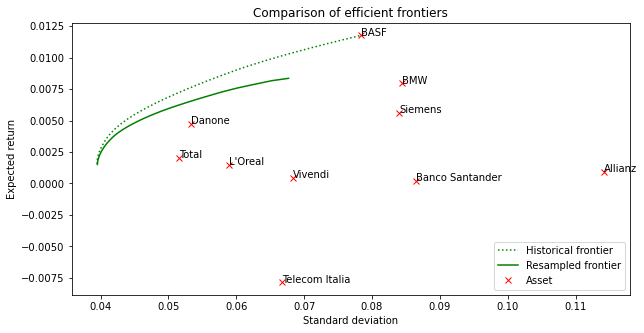

In [12]:
fig1 = plt.figure(num=1, facecolor='w', figsize=(10, 5))
ax = fig1.add_subplot(111)
plt.plot(V_Risk, V_Target, 'g:', label='Historical frontier')
plt.plot(S_Risk, S_Return, 'g-', label='Resampled frontier')
plt.plot(np.sqrt(np.diagonal(Sigma_hist)), means_hist, 'rx', label='Asset')
for i, txt in enumerate(frame1.columns):
   ax.annotate(txt, (np.sqrt(np.diagonal(Sigma_hist))[i],means_hist[i]))
plt.legend(loc=4,  frameon=True)
plt.xlabel('Standard deviation')
plt.ylabel('Expected return')
plt.title('Comparison of efficient frontiers')
plt.show()

Offensichtlich liegt die simulierte Effizienzkurve unterhalb der klassischen Effizienzkurve. Warum?

Wenn wir uns eine bestimmte Monte Carlo Ziehung ansehen, sagen wir $\theta_i$, und die dazugehörige Kurve zeichnen, kann diese rechts oder links von der ursprünglichen Kurve liegen. Wir verfolgen die Portfoliogewichte an diskreten Punkten. Wir mitteln diese Gewichte (nicht die Kurven) - und wenden diese Durchschnittsgewichte dann auf das Original $\theta$ an.

Wir wissen, dass die optimalen (effizienten) Portfoliogewichte, gegeben $\theta$, durch $a_K$ repräsentiert werden. Wenn wir $a^*_K$ auf $\theta$ anwenden muss folglich die resultierende Kurve rechts von der Originalkurve liegen. Mit anderen Worten, wenn $a_K$ effizient für $\theta$ ist, kann $a^*_K$ nicht auch effizient für $\theta$ sein. Jede einzelne simulierte Effizienzkurve ist zwar effizient gegenüber den jeweils dazugehörigen simulierten $\mu_i$ und $\Sigma_i$, jedoch ineffizient gegenüber der ursprünglichen historischen Schätzung $\mu$ und $\Sigma$. Ein auf der Grundlage des Portfolio-Resamplings ermitteltes Portfolio ist daher per Definition nicht mehr effizient für $\theta$, es berücksichtigt aber das Schätzrisiko bezogen auf das wahre $\theta$. 


Wir plotten nun in Form eines Balkendiagramms die zu den Effizienzkurven gehörenden Portfoliogewichte: 

1. Resampled-Effizienzkurve

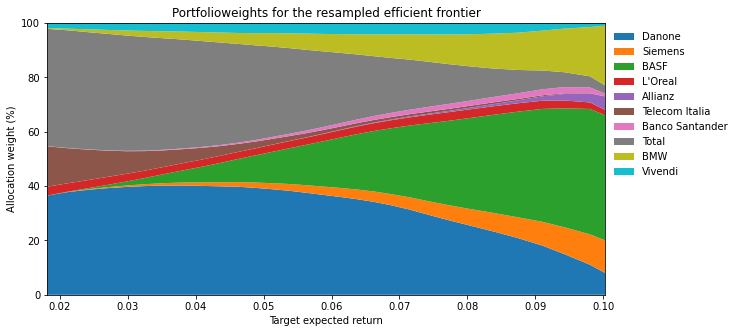

In [13]:
fig2 = plt.figure(num=2, facecolor='w', figsize=(10, 5))
plt.stackplot(S_Return*12, S_Weight.T*100) # annualised returns
plt.axis([np.min(S_Return*12), np.max(S_Return*12), 0.0, 100.0])
plt.legend(list(frame1.columns),
           loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)
plt.xlabel('Target expected return')
plt.ylabel('Allocation weight (%)')
plt.title('Portfolioweights for the resampled efficient frontier')
plt.show()

2. Klassische Effizienzkurve auf Basis einfacher historisch basierter Schätzung

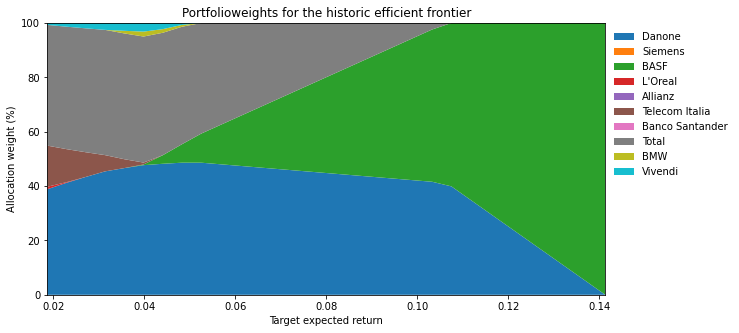

In [14]:
fig3 = plt.figure(num=3, facecolor='w', figsize=(10, 5))
plt.stackplot(V_Target*12, V_Weight.T*100)
plt.axis([np.min(V_Target*12), np.max(V_Target*12), 0.0, 100.0]) # annualised return
plt.legend(list(frame1.columns),
           loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)
plt.xlabel('Target expected return')
plt.ylabel('Allocation weight (%)')
plt.title('Portfolioweights for the historic efficient frontier')
plt.show()

Ein Vergleich der Diagramme zeigt, dass im Rahmen des Portfolio-Resamplings eindeutig eine höhere Anzahl an Wertpapieren in die Portfoliokonstruktion aufgenommen wird. Dadurch lässt sich eine höhere Diversifiktion der Portfolios erreichen. Zudem zeigen sich weniger plötzliche Verschiebungen in der Portfoliostruktur der einzelnen Wertpapiere. Die Portfoliozusammensetzung ist insgesamt diversifizierter und weniger volatil. Die stabilen Portfolioallokationen ergeben sich als Folge der Bildung durchschnittlicher Portfoliogewichte, so dass geringe Veränderungen in den Eingangsgrößen nunmehr lediglich zu geringen Veränderungen der optimierten Portfolios führen können. 

### Exkurs: Vergleich simulierter  vs. historischer Mittelwerte und Varianzen/Kovarianzen

Wir simulieren eine (d.h., ziehen zufällige Realisationen aus einer) multivariaten Normalverteilung. Durch Erhöhung der Anzahl `size` an Ziehungen nähern sich die simulierten Momente den wahren Momenten $\mu$ und $\Sigma$ der Verteilung an. 

In [18]:
np.random.seed(32)
df = pd.DataFrame(np.asarray(np.random.multivariate_normal(means_hist,\
                Sigma_hist, size = 50000)), columns=frame1.columns)
pd.DataFrame({'sim': df.mean().values, 'hist.': means_hist,\
             'difference':df.mean().values-means_hist}, \
             index=frame1.columns)

,sim,hist.,difference
Danone,0.004407,0.004711,-0.000304
Siemens,0.004495,0.005585,-0.001090
BASF,0.010784,0.011778,-0.000994
L'Oreal,0.000882,0.001505,-0.000623
Allianz,-0.000273,0.000947,-0.001220
Telecom Italia,-0.007887,-0.007870,-0.000017
Banco Santander,-0.000349,0.000191,-0.000540
Total,0.001659,0.002032,-0.000373
BMW,0.006899,0.007962,-0.001063
Vivendi,-0.000316,0.000421,-0.000737


### Graphische Darstellung der historischen und der $M$ simulierten Effizienzkurven

Abschließend plotten wir die originale Effizienzkurve zusammen mit den $M$ simulierten Effizienzkurven. 

Dazu generieren wir zwei Listen-Okjekte: `liste_Risk` für die Portfoliovarianz und `liste_Target` für die erwartete Portfoliorendite. Beide Listen sollen final $(1+M)$ Elemente (jeweils 1-D Arrays der Dimension $K$) enthalten. Jede Effizienzkurve besteht dabei aus $K$ Punkten.

Zunächst berechnen wir die historische Effizienzkurve über `ef_front` und weisen die 1-D (Dimension=K) Arrays  `Risk` (für $\sigma^2_P$) und `Target` (für $\mu_P$) den beiden Listen zu. Danach simulieren wir für $i=1,..., M$ auf Basis der Annahme einer multivariaten Normalverteilung für den Renditevektor die Werte der Eingabeparameter $\theta_i=\{\mu_i, \Sigma_i\}$ und berechnen jeweils die $M$ Effizienzkurven. Die beiden Arrays mit den Charakteristiken der Effizienzkurven ($\mu_{P,i}$ und $\sigma^2_{P,i}$) werden wiederum den Listen zugewiesen. 

Abschließend werden beide Listen in Arrays (d.h. $(M+1)xK$)-Matrizen transformiert und von der Funktion zurückgegeben. 

In [19]:
# function returns two lists with (1+M) elements; 
# each element is a 1-D array of dimension K;
# K is the number of points on the ef: K different target 
# expected portfolio returns and portfolio return std's
def resampled_frontiers(M, means_hist, Sigma_hist):
# M: number of Monte Carlo runs   
    np.random.seed(42)
    liste_Risk = []
    liste_Target = []
    # first, calculate the historical ef 
    _, Risk, Target = ef_front(means_hist, Sigma_hist)
    # and append to the two lists
    liste_Risk.append(Risk)
    liste_Target.append(Target)
    # now, calculate the M simulated ef's
    for i in range(M):
        df = pd.DataFrame(np.asarray(np.random.multivariate_normal(means_hist,\
                Sigma_hist, size = 110)), columns=frame1.columns)
        means = df.mean().values
        Sigma = df.cov().values
        # ef_front returns: weights, risk, target return! 
        _, Risk, Target = ef_front(means, Sigma)
        # and append to the lists
        liste_Risk.append(Risk)
        liste_Target.append(Target)
    liste_Risk = np.array(liste_Risk)
    liste_Target = np.array(liste_Target)
    return liste_Risk, liste_Target 


Die folgende Funktion `draw_efs` zeichnet nun die historische zusammen mit den $M$ simulierten Effizienzkurven. Hierfür werden die beiden Arrays der Funktion `resampled_frontiers` verwendet. 

In [20]:
def draw_efs(M, means_hist, Sigma_hist):
    Risk, Target = resampled_frontiers(M, means_hist, Sigma_hist)

    fig1 = plt.figure(num=1, facecolor='w', figsize=(10, 5))
    ax = fig1.add_subplot(111)
    plt.plot(Risk[0,:], Target[0,:], 'g:', label='Historical frontier')
    plt.plot(Risk[1,:], Target[1,:], 'b-', label='Resampled frontiers')
    for i in range(2,M+1):
        plt.plot(Risk[i,:], Target[i,:], 'b-')
    plt.plot(np.sqrt(np.diagonal(Sigma_hist)), means_hist, 'rx', label='Asset')
    for i, txt in enumerate(frame1.columns):
        ax.annotate(txt, (np.sqrt(np.diagonal(Sigma_hist))[i],means_hist[i]))
    plt.legend(loc=4,  frameon=True)
    plt.xlabel('Standard deviation')
    plt.ylabel('Expected return')
    plt.title('Historical and M simulated efficient frontiers')
    return plt.show()

Lassen Sie uns zum Abschluss zehn simulierte und die historische Effizienzkurve graphisch darstellen.

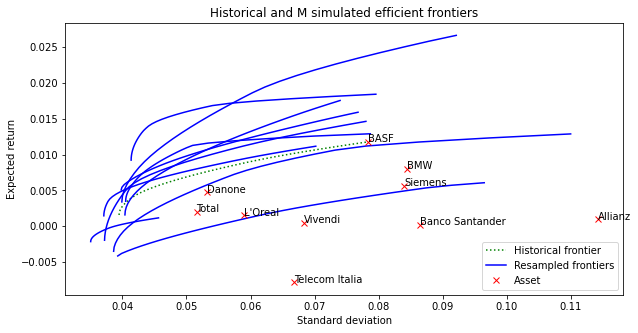

In [21]:
draw_efs(10, means_hist, Sigma_hist)

## Literatur

Michaud, R.O, Michaud, R.O., (2008). Efficient Asset Management: A Practical Guide to Stock Portfolio Optimization and Asset Allocation, 2nd Edition, Oxford University Press. 